# Demo of `cf-xarray`

In [1]:
import xarray as xr
import cf_xarray
import extract_model as em
import pandas as pd
from functools import partial


## Model output

We will use model output from several types of ocean models to demonstrate using the same commands with `cf-xarray`. The model output locations are based on what day it is, so here we defined "today".

In these examples, I read in the model output using a package called `extract_model` that knows the potential pitfalls of different models with the intention of mitigating those and adding attributes to the model output as needed. This is super important for `cf-xarray` to work correctly and is a work in progress. 

Another way to help `cf-xarray` work better is to use the built-in `ds.cf.guess_coord_axis(verbose=True)`.

In [2]:
today = pd.Timestamp.today()

### ROMS

In [4]:
try:
    url = ['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/TBOFS/fmrc/Aggregated_7_day_TBOFS_Fields_Forecast_best.ncd']
    ds_roms = xr.open_mfdataset(url, preprocess=em.preprocess)
except OSError:
    url = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/TBOFS/MODELS/%Y/%m/%d/nos.tbofs.fields.n001.%Y%m%d.t00z.nc'),
           today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/TBOFS/MODELS/%Y/%m/%d/nos.tbofs.fields.n002.%Y%m%d.t00z.nc')]
    ds_roms = xr.open_mfdataset(url, preprocess=em.preprocess)


oc_open: server error retrieving url: code=500 message="null"

CPU times: user 1.42 s, sys: 105 ms, total: 1.53 s
Wall time: 12.1 s


### POM

In [4]:
try:
    url = ['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/LOOFS/fmrc/Aggregated_7_day_LOOFS_Fields_Forecast_best.ncd']
    # This model isn't being properly identified by the preprocessing script so have to tell it it is a POM model
    pom_preprocess = partial(em.preprocess, model_type='POM')
    ds_pom = xr.open_mfdataset(url, preprocess=pom_preprocess)
except OSError:
    url = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LOOFS/MODELS/%Y/%m/%d/glofs.loofs.fields.nowcast.%Y%m%d.t00z.nc'),
           today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LOOFS/MODELS/%Y/%m/%d/glofs.loofs.fields.nowcast.%Y%m%d.t06z.nc')]
    # This model isn't being properly identified by the preprocessing script so have to tell it it is a POM model
    pom_preprocess = partial(em.preprocess, model_type='POM')
    ds_pom = xr.open_mfdataset(url, preprocess=pom_preprocess)



oc_open: server error retrieving url: code=500 message="null"

### SELFE

In [5]:
url = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n000.%Y%m%d.t03z.nc'),
       today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n001.%Y%m%d.t03z.nc')]
ds_selfe = xr.open_mfdataset(url, preprocess=em.preprocess)
# 

### ...Use ROMS First

In [5]:
ds = ds_roms

`cf-xarray` description for whole Dataset

In [6]:
ds.cf


- CF Roles:   grid_topology: ['grid']

Coordinates:
- CF Axes: * X: ['xi_psi', 'xi_rho', 'xi_u', 'xi_v']
           * Y: ['eta_psi', 'eta_rho', 'eta_u', 'eta_v']
           * Z: ['s_rho', 's_w']
           * T: ['ocean_time']

- CF Coordinates:   longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                    latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                    vertical: ['z_rho', 'z_w']
                  * time: ['ocean_time']

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                    longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                  * ocean_s_coordinate_g1: ['s_rho', 's_w']
                  * time: ['ocean_time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   sea_surface_elevation: ['zeta']
                    sea_water_practical_salinity: ['salt']
                    sea_water_temperature: ['temp']
                    upw

## Basic Operations

### Selecting and Slicing

#### Time

Access time:

In [7]:
ds.cf['T']

<xarray.DataArray 'ocean_time' (ocean_time: 2)>
array(['2022-08-10T19:00:00.000000000', '2022-08-10T20:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-08-10T19:00:00 2022-08-10T20...
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    _ChunkSizes:    512
    axis:           T
    standard_name:  time

Select time:

In [8]:
ds.cf.sel(T='2022-8-9T20', method='nearest').cf['T']

<xarray.DataArray 'ocean_time' ()>
array('2022-08-10T19:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    _ChunkSizes:    512
    axis:           T
    standard_name:  time

Select time by index:

In [9]:
ds.cf.isel(T=0).cf['T']

<xarray.DataArray 'ocean_time' ()>
array('2022-08-10T19:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    _ChunkSizes:    512
    axis:           T
    standard_name:  time

#### Horizontal Space Dimensions

You can use these in a meaningful way if your horizontal dimensions are your horizontal coordinates. That is, for example, that you have a vector of longitudes and latitudes that define your (rectilinear) grid instead of a 2D or unstructured grid. You can still do it in these later cases but it may not be as meaningful.

Slice 

In [10]:
ds.cf.isel(X=slice(0,10))

<xarray.Dataset>
Dimensions:          (ocean_time: 2, tracer: 2, boundary: 4, s_rho: 11,
                      s_w: 12, eta_rho: 290, xi_rho: 10, eta_u: 290, xi_u: 10,
                      eta_v: 289, xi_v: 10, eta_psi: 289, xi_psi: 10)
Coordinates: (12/21)
  * s_rho            (s_rho) float64 -0.9545 -0.8636 ... -0.1364 -0.04545
  * s_w              (s_w) float64 -1.0 -0.9091 -0.8182 ... -0.1818 -0.09091 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 10), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 10), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 10), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 10), meta=np.ndarray>
    ...               ...
  * eta_rho          (eta_rho) int64 0 1 2 3 4 5 6 ... 284 285 286 287 288 289
  * eta_u            (eta_u) int64 0 1 2 3 4 5 6 ... 283 284 285 286 287 288 289
  * eta_v            (eta_v) int64 0 1 2 3 4 5 6 ... 282 283 284 285 286 287 288
  * eta_psi          (eta_psi) int64 0 1 2 3 4 5 6 ... 283 284 285 286 287 288
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 11, 290, 10), meta=np.ndarray>
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 12, 290, 10), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/82)
    ntimes           (ocean_time) int32 4320 4320
    ndtfast          (ocean_time) int32 10 10
    dt               (ocean_time) float64 5.0 5.0
    dtfast           (ocean_time) float64 0.5 0.5
    dstart           (ocean_time) datetime64[ns] 2022-08-10T18:00:00 2022-08-...
    nHIS             (ocean_time) int32 720 720
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 12, 290, 10), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 290, 10), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 290, 10), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 290, 10), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 290, 10), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 290, 10), meta=np.ndarray>
Attributes: (12/32)
    file:                            nos.tbofs.fields.nowcast.20220811.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           tbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          008x016
    history:                         ROMS/TOMS, Version 3.9, Thursday - Augus...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               11

#### Variable

Select variable by `standard_name`:

In [11]:
var = 'sea_water_temperature'

ds.cf[var]

<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 11, eta_rho: 290, xi_rho: 176)>
dask.array<concatenate, shape=(2, 11, 290, 176), dtype=float32, chunksize=(1, 11, 290, 176), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9545 -0.8636 -0.7727 ... -0.1364 -0.04545
  * ocean_time  (ocean_time) datetime64[ns] 2022-08-10T19:00:00 2022-08-10T20...
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
Attributes:
    long_name:      potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    _ChunkSizes:    [  1  11 290 176]
    standard_name:  sea_water_temperature

Create your own custom vocabulary for variables that can search the variable metadata with rules you write, which can use regular expressions.

In [12]:
criteria = {'temp': {'units': 'Celsius'}}

cf_xarray.set_options(custom_criteria=criteria)

ds.cf['temp']

<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 11, eta_rho: 290, xi_rho: 176)>
dask.array<concatenate, shape=(2, 11, 290, 176), dtype=float32, chunksize=(1, 11, 290, 176), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9545 -0.8636 -0.7727 ... -0.1364 -0.04545
  * ocean_time  (ocean_time) datetime64[ns] 2022-08-10T19:00:00 2022-08-10T20...
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
Attributes:
    long_name:      potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    _ChunkSizes:    [  1  11 290 176]
    standard_name:  sea_water_temperature

### Plotting

Plot first time step at surface.

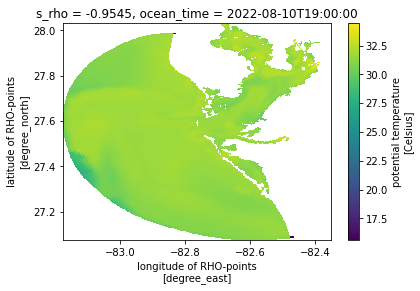

In [13]:
ds.cf[var].cf.isel(T=0).cf.isel(Z=0).cf.plot(x='longitude', y='latitude')

## AP Level

### Create Bounding Box

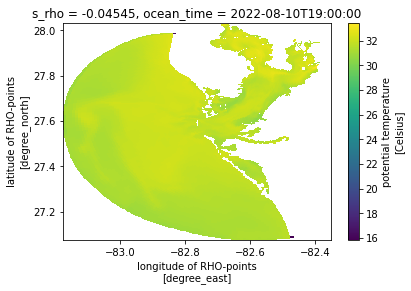

In [14]:
da = ds.cf[var].cf.isel(T=0, Z=-1)

dd = 1
lon0 = da.cf['longitude'].mean()
lat0 = da.cf['latitude'].mean()
bbox = [lon0 - dd, lat0 - dd, lon0 + dd, lat0 + dd]

box = (
    (bbox[0] < da.cf["longitude"])
    & (da.cf["longitude"] < bbox[2])
    & (bbox[1] < da.cf["latitude"])
    & (da.cf["latitude"] < bbox[3])
).compute()

da.where(box, drop=True).cf.plot(x='longitude', y='latitude')

### Decode Vertical Coords

In [15]:
outnames = { Z: Z.replace('s', 'z') for Z in ds.cf.axes['Z']}

ds.cf.decode_vertical_coords(outnames=outnames)
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 2, tracer: 2, boundary: 4, s_rho: 11,
                      s_w: 12, eta_rho: 290, xi_rho: 176, eta_u: 290,
                      xi_u: 175, eta_v: 289, xi_v: 176, eta_psi: 289,
                      xi_psi: 175)
Coordinates: (12/21)
  * s_rho            (s_rho) float64 -0.9545 -0.8636 ... -0.1364 -0.04545
  * s_w              (s_w) float64 -1.0 -0.9091 -0.8182 ... -0.1818 -0.09091 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(290, 176), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 175), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(290, 175), meta=np.ndarray>
    ...               ...
  * eta_rho          (eta_rho) int64 0 1 2 3 4 5 6 ... 284 285 286 287 288 289
  * eta_u            (eta_u) int64 0 1 2 3 4 5 6 ... 283 284 285 286 287 288 289
  * eta_v            (eta_v) int64 0 1 2 3 4 5 6 ... 282 283 284 285 286 287 288
  * eta_psi          (eta_psi) int64 0 1 2 3 4 5 6 ... 283 284 285 286 287 288
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 11, 290, 176), meta=np.ndarray>
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 12, 290, 176), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/82)
    ntimes           (ocean_time) int32 4320 4320
    ndtfast          (ocean_time) int32 10 10
    dt               (ocean_time) float64 5.0 5.0
    dtfast           (ocean_time) float64 0.5 0.5
    dstart           (ocean_time) datetime64[ns] 2022-08-10T18:00:00 2022-08-...
    nHIS             (ocean_time) int32 720 720
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 12, 290, 176), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 290, 176), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 11, 290, 176), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 290, 176), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 290, 176), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 290, 176), meta=np.ndarray>
Attributes: (12/32)
    file:                            nos.tbofs.fields.nowcast.20220811.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           tbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          008x016
    history:                         ROMS/TOMS, Version 3.9, Thursday - Augus...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               11

In [16]:
ds.cf


- CF Roles:   grid_topology: ['grid']

Coordinates:
- CF Axes: * X: ['xi_psi', 'xi_rho', 'xi_u', 'xi_v']
           * Y: ['eta_psi', 'eta_rho', 'eta_u', 'eta_v']
           * Z: ['s_rho', 's_w']
           * T: ['ocean_time']

- CF Coordinates:   longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                    latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                  * time: ['ocean_time']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['lat_psi', 'lat_rho', 'lat_u', 'lat_v']
                    longitude: ['lon_psi', 'lon_rho', 'lon_u', 'lon_v']
                  * ocean_s_coordinate_g1: ['s_rho', 's_w']
                  * time: ['ocean_time']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   sea_surface_elevation: ['zeta']
                    sea_water_practical_salinity: ['salt']
                    sea_water_temperature: ['temp']
                    upward_sea_water